# Machine Learning Classifier Evaluation

Fit a range of ML classifiers to each subject in the NAGL study, and create a tbale of metrics, including mean accuracy from 10-fold stratified corss-validation, and generalization accuracy of the model to a test set (20% of original data).

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns

from glob import glob
from pathlib import Path
import yaml
from yaml import CLoader as Loader
import os.path as op

import mne
from mne import io, EvokedArray

from mne.decoding import Vectorizer, get_coef
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score

from mne.decoding import LinearModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# import a linear classifier from mne.decoding
# from mne.decoding import CSP

mne.set_log_level(verbose='Warning')

## Read config file

In [4]:
bids_root = '../..'

cfg_file = op.join(bids_root, 'config.yml')
with open(cfg_file, 'r') as f:
    config = yaml.load(f, Loader=Loader)

study_name = config['study_name']
task = config['task']
data_type = config['data_type']
eog = config['eog']
montage_fname = config['montage_fname']
n_jobs = config['n_jobs']
epoch_p =  {k: v for d in config['analysis_settings'] for k, v in d.items()}
baseline = eval(epoch_p['baseline'])

cl_p = {k: v for d in config['classification'] for k, v in d.items()}


## Paths

In [5]:
source_path = op.join(bids_root, 'derivatives', 'erp_preprocessing')

derivatives_path = op.join(bids_root, 'derivatives', 'erp_classification_test_' + str(round(cl_p['test_size'] * 100)) + '_pct')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)

out_path = op.join(derivatives_path, 'data')
if Path(out_path).exists() == False:
    Path(out_path).mkdir(parents=True)

report_path = op.join(derivatives_path, 'reports')
if Path(report_path).exists() == False:
    Path(report_path).mkdir(parents=True)

fig_path = op.join(derivatives_path, 'figures')
if Path(fig_path).exists() == False:
    Path(fig_path).mkdir(parents=True) 
    
tab_path = op.join(derivatives_path, 'tables')
if Path(tab_path).exists() == False:
    Path(tab_path).mkdir(parents=True) 
    
epochs_suffix = '-epo.fif'

# output files
out_file = op.join(tab_path, 'classification_accuracy_results.csv')
summary_file =  op.join(tab_path, 'classification_accuracy_summary.csv')
plot_stem = op.join(fig_path, 'plot_')
fig_format = 'pdf'

## List of subjects

In [6]:
prefix = 'sub-'
subjects = sorted([s[-7:] for s in glob(source_path + '/' + prefix + '*')])
print("n subjects = ", len(subjects))

n subjects =  31


## Define conditions and labels

In [7]:
conditions = ['Angry/Grey/target', 'Angry/Grey/nontarget',
              'Angry/Red/target', 'Angry/Red/nontarget',
              'Neutral/Grey/target', 'Neutral/Grey/nontarget',
              'Neutral/Red/target', 'Neutral/Red/nontarget',
              'target', 'nontarget'
             ]

coi = ['target', 'nontarget']

contrasts = {'Angry/Grey':['Angry/Grey/target', 'Angry/Grey/nontarget'],
             'Angry/Red':['Angry/Red/target', 'Angry/Red/nontarget'],
             'Neutral/Grey':['Neutral/Grey/target', 'Neutral/Grey/nontarget'],
             'Neutral/Red':['Neutral/Red/target', 'Neutral/Red/nontarget'],
            }

## Load in data

- we subtract the mean in the baseline period (set in config)
- we also decimate the data by a factor of 4 (i.e., take only every 4th data point), to speed up computation with no predicted loss in accuracy (given that data are lowpass filtered at 30 Hz - so relative to the original sampling rate of 512 Hz, a 4x decimation preserves frequencies below 128 Hz, or considering the Nyquist, worst case below 42 Hz)

In [6]:
epochs = {}
for subject in subjects:
    subj_path = op.join(source_path, subject, 'eeg')
    epochs[subject] = mne.read_epochs(str(subj_path + '/' + subject + '_task-' + task + '-epo.fif'),
                                         verbose=None, 
                                         preload=True).apply_baseline(baseline).decimate(4)

### Define transformers and classifiers

In [7]:
rng = np.random.RandomState(cl_p['random_state'])
vectorizer = Vectorizer()
scaler = StandardScaler()
logreg = LinearModel(LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=n_jobs, verbose=False, random_state=rng))
lr_sdg = SGDClassifier(loss='log', max_iter=10000, verbose=False, random_state=rng)
lda = LinearDiscriminantAnalysis()
# csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
svc = LinearSVC(C=8, max_iter=10000, verbose=False, random_state=rng) 
svm_sgd = SGDClassifier(loss='hinge', max_iter=10000, verbose=False, random_state=rng)
rf = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs, verbose=True, random_state=rng, min_samples_split=20)
nb = GaussianNB()

classifiers = {'LR':logreg, 'LR_SGD':lr_sdg, 'LDA':lda, 'SVM':svc, 'SVM_SGD':svm_sgd, 'RF':rf, 'NB':nb }
# For cross-validation
k = 10
# shuffle=False to preserve temporal order of trials
# from sklearn:  if samples...are ordered by...time..., then shuffling the data 
#   will likely lead to a model that is overfit and an inflated validation score: 
#   it will be tested on samples that are artificially similar (close in time) to training samples
cv = StratifiedKFold(n_splits=k, shuffle=False)

## Classification loop
For each subject and condition, fit each classifier and score

In [8]:
%%time

acc_tab = pd.DataFrame()
acc_tab_list = []

for subject in subjects:
    print('\n-------\n' + subject)
    
    for contr, conds in contrasts.items():
        print('-------\n' + contr)
        subj_epochs = epochs[subject][conds]

        # create a list of labels from event codes mapped to event_id
        event_id_rev = dict(zip(subj_epochs.event_id.values(), subj_epochs.event_id.keys()))
        labels_all = [event_id_rev[e] for e in subj_epochs.events[:, 2]]
        labels_all = pd.DataFrame(labels_all)[0].str.split('/', expand=True).rename(columns={0:'Emotion', 1:'Colour', 2:'Status', 3:'Location'})
        label_map = {'target':1, 'nontarget':0}
        labels_all['labels'] = labels_all['Status'].map(label_map)
        labels = labels_all['labels']

        # Extract data from subj_epochs 
        X = subj_epochs.get_data()    

        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, labels,
                                                            stratify=labels,
                                                            test_size=cl_p['test_size'], 
                                                            random_state=cl_p['random_state'])

        for c_name, c in classifiers.items():
            print('-------\nRunning classifier: ' + c_name)
            clf = Pipeline([('Vectorizer', vectorizer),
                            ('Scaler', scaler),
                            (c_name, c)
                           ])

            # Fit model then get prediction accuracy on test set
            print('Cross validate...')
            cv_cv = cross_validate(clf, X_train, y_train, 
                                   scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                                   cv=cv,
                                   n_jobs=cl_p['n_jobs'])      
            print('Training...')
            train_fit = clf.fit(X_train, y_train)  # should we also include cv here? - No, that doesn't make sense. Fitting should be on the whole training set
            print('Predicting...')
            y_pred = clf.predict(X_test)

            print('Scoring...')
            acc_tab_list.append(pd.DataFrame({'participant_id':subject,
                                              'Condition':contr,
                                              'Classifier':c_name,
                                              'CV_accuracy':cv_cv['test_accuracy'].mean().round(3) * 100,
                                              'Test_accuracy':accuracy_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_precision':cv_cv['test_precision'].mean().round(3) * 100,
                                              'Test_precision':precision_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_recall':cv_cv['test_recall'].mean().round(3) * 100,
                                              'Test_recall':recall_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_f1':cv_cv['test_f1'].mean().round(3) * 100,
                                              'Test_f1':f1_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_ROC_AUC':cv_cv['test_roc_auc'].mean().round(3) * 100,
                                              'Test_ROC_AUC':roc_auc_score(y_test, y_pred).round(3) * 100,
                                              
                                              'Fit Time':cv_cv['fit_time'].mean().round(3)
                                             }, index=[0]
                                            )
                               )
                            
acc_tab = pd.concat(acc_tab_list)
acc_tab.to_csv(out_file, index=False)


-------
sub-001
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-002
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-003
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-004
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-005
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-006
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-007
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-008
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-009
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-010
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-011
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-012
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-013
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-014
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-015
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-017
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-018
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-019
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-020
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-021
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-022
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-023
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-024
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-025
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-026
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-027
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-028
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-029
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-030
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-031
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Predicting...


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...

-------
sub-032
-------
Angry/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Angry/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Grey
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
-------
Neutral/Red
-------
Running classifier: LR
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LR_SDG
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: LDA
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: SVM_SGD
Cross validate...
Training...
Predicting...
Scoring...
-------
Running classifier: RF
Cross validate...
Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicting...
Scoring...
-------
Running classifier: NB
Cross validate...
Training...
Predicting...
Scoring...
CPU times: user 39min 39s, sys: 35min 36s, total: 1h 15min 16s
Wall time: 49min 4s


From one test run:
- **Architect**: 26 min 25 s
- **Aaron's laptop**: 9 min 55 s

## Full results grouped by participant

In [9]:
acc_tab.groupby(['participant_id', 'Condition', 'Classifier']).mean()

CV_accuracy  Test_accuracy  \
participant_id Condition    Classifier                               
sub-001        Angry/Grey   LDA                91.3           92.7   
                            LR                 94.2           93.3   
                            LR_SDG             92.7           89.3   
                            NB                 77.8           75.3   
                            RF                 84.3           83.1   
                            SVM                93.9           94.4   
                            SVM_SGD            91.1           88.2   
               Angry/Red    LDA                93.6           89.8   
                            LR                 94.2           94.4   
                            LR_SDG             91.7           92.1   
                            NB                 77.1           76.3   
                            RF                 85.9           86.4   
                            SVM                93.9           94.9   
                            SVM_SGD            92.9           91.5   
               Neutral/Grey LDA                92.9           89.9   
                            LR                 94.2           96.1   
                            LR_SDG             91.6           89.9   
                            NB                 81.2           83.8   
                            RF                 83.3           83.8   
                            SVM                92.0           96.6   
                            SVM_SGD            91.3           91.6   
               Neutral/Red  LDA                92.3           93.9   
                            LR                 94.9           93.9   
                            LR_SDG             92.8           94.4   
                            NB                 77.1           78.8   
                            RF                 85.8           85.5   
                            SVM                94.7           96.6   
                            SVM_SGD            92.7           94.4   
sub-002        Angry/Grey   LDA                87.3           85.5   
                            LR                 91.2           91.9   
                            LR_SDG             91.2           89.6   
                            NB                 83.0           77.5   
                            RF                 85.4           83.8   
                            SVM                87.0           90.2   
                            SVM_SGD            89.7           91.3   
               Angry/Red    LDA                90.3           91.9   
                            LR                 93.3           93.6   
                            LR_SDG             93.0           91.3   
                            NB                 90.0           89.0   
                            RF                 86.3           87.8   
                            SVM                92.2           92.4   
                            SVM_SGD            92.3           92.4   
               Neutral/Grey LDA                88.4           91.5   
                            LR                 93.5           92.7   
                            LR_SDG             91.9           91.0   
                            NB                 82.2           79.1   
                            RF                 86.0           87.0   
                            SVM                88.0           91.0   
                            SVM_SGD            92.5           91.5   
               Neutral/Red  LDA                88.0           90.3   
                            LR                 93.7           95.5   
                            LR_SDG             92.6           93.8   
                            NB                 85.6           85.8   
                            RF                 85.6           87.5   
                            SVM                90.2           92.6   
                            SVM_SGD            91.

## Tables of results in different groupings

In [10]:
acc_tab.head()

,participant_id,Condition,Classifier,CV_accuracy,Test_accuracy,CV_precision,Test_precision,CV_recall,Test_recall,CV_f1,Test_f1,CV_ROC_AUC,Test_ROC_AUC,Fit Time
0,sub-001,Angry/Grey,LR,94.2,93.3,90.6,82.1,73.4,76.7,80.6,79.3,96.2,86.6,1.339
0,sub-001,Angry/Grey,LR_SDG,92.7,89.3,94.4,70.4,59.7,63.3,72.3,66.7,94.4,79.0,0.159
0,sub-001,Angry/Grey,LDA,91.3,92.7,72.3,74.3,79.5,86.7,75.4,80.0,94.1,90.3,1.611
0,sub-001,Angry/Grey,SVM,93.9,94.4,76.8,77.8,91.4,93.3,83.2,84.8,97.1,94.0,2.086
0,sub-001,Angry/Grey,SVM_SGD,91.1,88.2,90.1,71.4,52.0,50.0,65.3,58.8,93.7,73.0,0.193


In [11]:
acc_tab.groupby(['Condition', 'Classifier']).describe()

CV_accuracy                                          \
                              count       mean       std   min    25%   50%   
Condition    Classifier                                                       
Angry/Grey   LDA               31.0  92.170968  4.346814  83.6  88.45  93.5   
             LR                31.0  93.987097  3.124499  86.3  91.20  94.7   
             LR_SDG            31.0  93.025806  3.227070  85.5  90.65  93.8   
             NB                31.0  82.561290  6.033610  69.4  77.90  83.3   
             RF                31.0  87.954839  3.678391  83.6  84.65  86.5   
             SVM               31.0  93.077419  4.341560  80.7  91.00  94.6   
             SVM_SGD           31.0  92.783871  3.289792  85.5  89.90  93.8   
Angry/Red    LDA               31.0  92.661290  4.921157  81.4  89.75  93.5   
             LR                31.0  94.206452  3.699003  85.4  92.00  94.2   
             LR_SDG            31.0  92.929032  3.909918  83.8  90.90  93.0   
             NB                31.0  82.777419  7.805071  67.1  77.10  82.8   
             RF                31.0  88.367742  4.303285  82.7  84.90  86.9   
             SVM               31.0  92.970968  3.953159  83.3  92.00  93.9   
             SVM_SGD           31.0  93.148387  3.781699  83.5  90.80  93.3   
Neutral/Grey LDA               31.0  91.529032  4.223442  82.7  88.35  92.2   
             LR                31.0  93.519355  3.218428  86.6  91.45  94.2   
             LR_SDG            31.0  92.329032  3.084822  86.4  89.95  92.2   
             NB                31.0  82.367742  6.157672  68.1  78.60  81.9   
             RF                31.0  87.480645  3.703190  83.0  84.45  87.1   
             SVM               31.0  92.080645  3.870178  82.5  89.80  92.6   
             SVM_SGD           31.0  92.296774  3.164120  86.5  90.35  92.2   
Neutral/Red  LDA               31.0  92.638710  3.370527  84.9  90.55  92.6   
             LR                31.0  94.487097  2.336057  89.0  93.25  94.6   
             LR_SDG            31.0  93.112903  2.939358  86.4  91.10  93.1   
             NB                31.0  82.548387  7.400264  62.9  77.80  83.3   
             RF                31.0  88.254839  3.760216  83.3  84.70  88.3   
             SVM               31.0  93.361290  2.781568  86.4  91.45  93.9   
             SVM_SGD           31.0  93.096774  2.847512  86.7  91.00  92.9   

                                     Test_accuracy                             \
                           75%   max         count       mean       std   min   
Condition    Classifier                                                         
Angry/Grey   LDA         95.20  99.2          31.0  92.483871  4.534247  83.3   
             LR          96.45  98.6          31.0  94.506452  3.577796  86.3   
             LR_SDG      95.35  98.5          31.0  93.048387  3.850963  86.1   
             NB          88.00  91.7          31.0  83.032258  6.691855  69.4   
             RF          91.30  94.7          31.0  88.003226  4.117806  82.8   
             SVM         96.40  98.5          31.0  92.929032  4.577495  79.6   
             SVM_SGD     95.00  97.9          31.0  93.145161  4.085408  85.0   
Angry/Red    LDA         96.65  98.5          31.0  92.661290  4.586769  78.6   
             LR          97.20  99.1          31.0  94.654839  3.406840  85.5   
             LR_SDG      96.10  98.2          31.0  92.967742  3.972689  82.2   
             NB          90.15  95.5          31.0  82.580645  6.752057  65.3   
             RF          91.95  96.1          31.0  88.758065  4.084424  83.3   
             SVM         95.85  97.6          31.0  93.925806  3.868330  80.3   
             SVM_SGD     96.10  98.3          31.0  93.096774  3.818855  83.9   
Neutral/Grey LDA         95.30  97.2          31.0  91.290323  4.686744  83.3   
             LR          96.30  97.6          31.0  94.348387  3.217853  86.8   
             LR_SDG      94.85  96.

### Save descriptives table to CSV

In [12]:
acc_tab.groupby(['Condition', 'Classifier']).describe().to_csv(summary_file)

In [11]:
acc_tab = pd.read_csv(out_file)

In [12]:
acc_tab.head()

,participant_id,Condition,Classifier,CV_accuracy,Test_accuracy,CV_precision,Test_precision,CV_recall,Test_recall,CV_f1,Test_f1,CV_ROC_AUC,Test_ROC_AUC,Fit Time
0,sub-001,Angry/Grey,LR,94.2,93.3,90.6,82.1,73.4,76.7,80.6,79.3,96.2,86.6,1.339
1,sub-001,Angry/Grey,LR_SDG,92.7,89.3,94.4,70.4,59.7,63.3,72.3,66.7,94.4,79.0,0.159
2,sub-001,Angry/Grey,LDA,91.3,92.7,72.3,74.3,79.5,86.7,75.4,80.0,94.1,90.3,1.611
3,sub-001,Angry/Grey,SVM,93.9,94.4,76.8,77.8,91.4,93.3,83.2,84.8,97.1,94.0,2.086
4,sub-001,Angry/Grey,SVM_SGD,91.1,88.2,90.1,71.4,52.0,50.0,65.3,58.8,93.7,73.0,0.193


## Visualize results

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


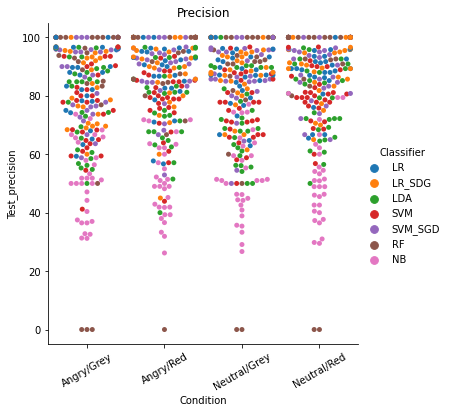

In [13]:
ax = sns.catplot(kind='swarm', 
                data=acc_tab,
                y='Test_precision', x='Condition', hue='Classifier'
                ).set(title='Precision')
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'precision_swarmplot' + '.' + fig_format)

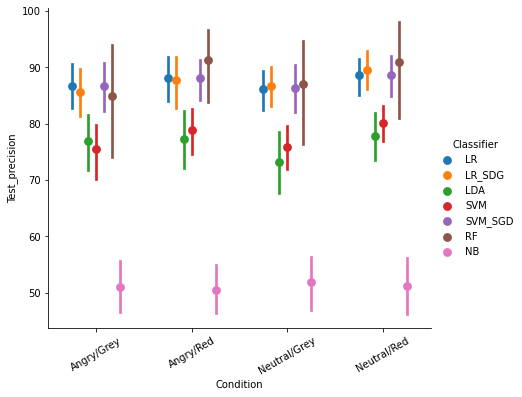

In [19]:
ax = sns.catplot(kind='point', join=False, dodge=.5,
            data=acc_tab,
            y='Test_precision', x='Condition', hue='Classifier', 
            aspect=1.2
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'precision_pointplot' + '.' + fig_format)

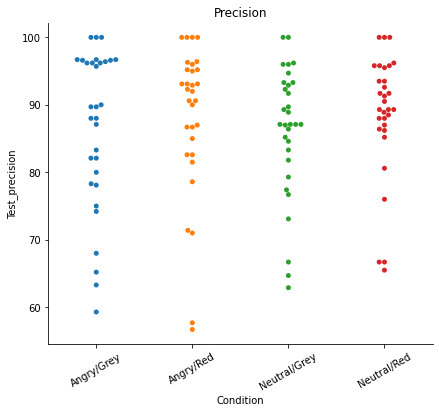

In [21]:
ax = sns.catplot(kind='swarm', 
                data=acc_tab[acc_tab['Classifier'] == 'LR'],
                y='Test_precision', x='Condition',  legend=False,
                  aspect=1.2
                ).set(title='Precision')
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'precision_swarmplot' + '.' + fig_format)

### Accuracy

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 12.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


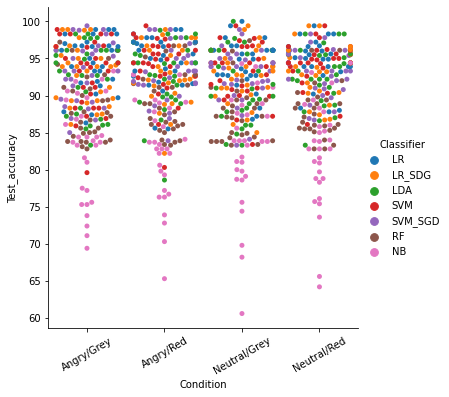

In [15]:
ax = sns.catplot(kind='swarm', 
            data=acc_tab,
            y='Test_accuracy', x='Condition', hue='Classifier', 
            aspect=1
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'accuracy_swarmplot_by_subj' + '.' + fig_format)

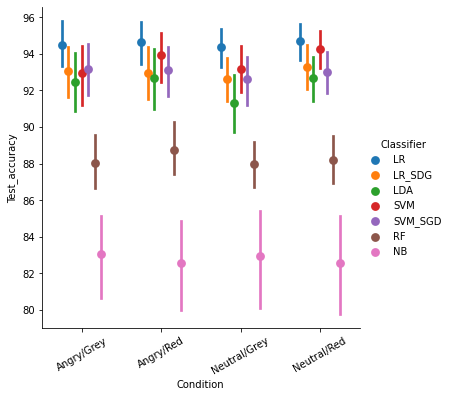

In [16]:
ax = sns.catplot(kind='point', join=False, dodge=.5,
            data=acc_tab,
            y='Test_accuracy', x='Condition', hue='Classifier', 
            aspect=1
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'accuracy_pointplot_by_subj' + '.' + fig_format)

In [ ]:
ax = sns.catplot(kind='point', join=False,
                data=acc_tab,
                y='Test_accuracy', x='Condition', hue='Classifier', 
                 col='participant_id', col_wrap=5,
                aspect=.5
                )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'accuracy_swarmplot_by_subj' + '.' + fig_format)